In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import distributions
import torchvision
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt


In [2]:
train = datasets.MNIST("../data/", train=True, download=True, transform=transforms.ToTensor())
test = datasets.MNIST("../data/", train=False, download=True, transform=transforms.ToTensor())

In [3]:
IM_SIZE = 28 * 28
IM_SHAPE = (28, 28)
CPU_training = False
BATCH = 64
EPOCHS = 15

use_cuda =  torch.cuda.is_available() and not CPU_training
device = torch.device("cuda" if use_cuda else "cpu")

trainset = torch.utils.data.DataLoader(train, batch_size=BATCH, shuffle=True, num_workers=7, pin_memory=use_cuda)
testset = torch.utils.data.DataLoader(test, batch_size=BATCH, shuffle=False, num_workers=7, pin_memory=use_cuda)

In [4]:
def nets(size): 
    hidden_f = 4    
    return nn.Sequential(nn.Linear(size, size*hidden_f),
                         nn.ReLU(True), 
                         nn.Linear(size*hidden_f, size*hidden_f), 
                         nn.ReLU(True), 
                         nn.Linear(size*hidden_f, size),
                         nn.Sigmoid())
def nett(size):
    hidden_f = 4
    return nn.Sequential(nn.Linear(size, size*hidden_f),
                         nn.ReLU(True), 
                         nn.Linear(size*hidden_f, size*hidden_f*2), 
                         nn.ReLU(True), 
                         nn.Linear(size*hidden_f*2, size*hidden_f), 
                         nn.ReLU(True), 
                         nn.Linear(size*hidden_f, size))

class CouplingLayer(nn.Module):
    def __init__(self, size, reverse=False):
        super().__init__()
        self.size = size // 2 
        self.translate = nett(self.size)
        self.scale = nets(self.size)
        self.reverse = -1 if reverse else 1
        
    def forward(self, args):
        if self.training: 
            x, log_det_J = args
        else:
            x = args
        x1, x2 = torch.split(x, self.size, 1)[::self.reverse]
        s = self.scale(x1)
        t = self.translate(x1)
        y2 = x2 * torch.exp(s) + t
        y = torch.cat((x1, y2), 1)
        if self.training:
            log_det_J += s.sum(dim=1)
            return y, log_det_J
        return y
    
class CouplingLayer_nice(nn.Module):
    def __init__(self, size, reverse=False):
        super().__init__()
        self.size = size // 2 
        self.translate = nett(self.size)
        self.reverse = -1 if reverse else 1
        
    def forward(self, x):
        x1, x2 = torch.split(x, self.size, 1)[::self.reverse]
        t = self.translate(x1)
        y2 = x2 + t
        y = torch.cat((x1, y2), 1)
        return y

class HH(nn.Module):
    def __init__(self, size, num_vectors=None):
        super().__init__()
        self.size = size
        self.num_vectors = num_vectors or 2 * (self.size // 2 + 1)
        self.vectors = nn.Parameter(torch.Tensor(self.num_vectors, self.size, 1))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.uniform_(self.vectors, -1, 1)
        self.vectors.data.copy_(self.vectors / self.vectors.norm(dim=1, keepdim=True))

    def forward(self, x):
        Q = self.bmm_naive_cascade()
        return x @ Q.t()

    def inverse(self, x):
        Q = self.bmm_naive_cascade()
        return x @ Q

    # Householder transformation
    def _get_bmm_householder_matrices(self):
        N, S, _ = self.vectors.size()

        outer = torch.bmm(self.vectors, self.vectors.transpose(1, 2))
        inner = torch.bmm(self.vectors.transpose(1, 2), self.vectors)
        I = torch.eye(S, device=self.vectors.device).expand(N, -1, -1)
        hh_matrices = I - 2 * outer / (inner + 1e-16)
        return hh_matrices

    @staticmethod
    def _reduce_mm(matrices):
        Q = matrices[0]
        for M in matrices[1:]:
            Q = torch.mm(Q, M)
        return Q


    def bmm_naive_cascade(self):
        """
        Args:   
            vectors: [NumVectors, Size, 1]
        Output:
            Q: [Size, Size]
        """
        matrices = self._get_bmm_householder_matrices()
        return HH._reduce_mm(matrices)

In [5]:
class RealNVP(nn.Module):
    def __init__(self, size):
        super().__init__()
        self.prior = distributions.MultivariateNormal(torch.zeros(size, device=device), torch.eye(size, device=device))
        self.encoder = nn.Sequential(CouplingLayer(size),
                                     HH(size, 20),
                                     CouplingLayer(size, True),
                                     HH(size, 20),
                                     CouplingLayer(size), 
                                     HH(size, 20),
                                     CouplingLayer(size, True),
                                     HH(size, 20),
                                     CouplingLayer(size), 
                                     HH(size, 20),
                                     CouplingLayer(size, True))
    
    def forward(self, x):
        return self.encoder(x)
    
    def backward(self, y):
        return self.encoder[::-1](y)
    
    def sample(self, batchSize=1):
        y = self.prior.sample((batchSize,))
        return self.backward(y)
    
    def log_prob(self, x):
        y, logp = self(x)
        return self.prior.log_prob(y) - logp
    
class Nice(nn.Module):
    def __init__(self, size):
        super().__init__()
        self.prior = distributions.MultivariateNormal(torch.zeros(size, device=device), torch.eye(size, device=device))
        self.encoder = nn.Sequential(CouplingLayer_nice(size), 
                                     CouplingLayer_nice(size, True),
                                     HH(size, 20),
                                     CouplingLayer_nice(size), 
                                     CouplingLayer_nice(size, True),
                                     HH(size, 20),
                                     CouplingLayer_nice(size), 
                                     CouplingLayer_nice(size, True),
                                     HH(size, 20),
                                     CouplingLayer_nice(size), 
                                     CouplingLayer_nice(size, True),
                                     HH(size, 20),
                                     CouplingLayer_nice(size), 
                                     CouplingLayer_nice(size, True))
    
    def forward(self, x):
        return self.encoder(x)
    
    def backward(self, y):
        return self.encoder[::-1](y)
    
    def sample(self, batchSize=1):
        y = self.prior.sample((batchSize,))
        return self.backward(y)
    
    def log_prob(self, x):
        y = self(x)
        return self.prior.log_prob(y)    

In [6]:
def train(network):
    net = network(IM_SIZE).to(device).train()
    optimizer = optim.Adam(net.parameters())

    for epoch in range(EPOCHS):
        for X, _ in trainset:
            X = X.view(-1, IM_SIZE).to(device)
            optimizer.zero_grad()
            if isinstance(net, Nice):
                loss = -net.log_prob(X).mean()
            else:
                loss = -net.log_prob((X, X.new_zeros(X.shape[0]))).mean()
            loss.backward(retain_graph=True)
            optimizer.step()      
            break
        break
        print(epoch, loss)
    
    return net

In [7]:
net_RealNVP = train(Nice)


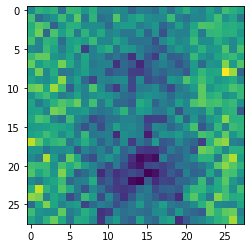

In [8]:
net_RealNVP.eval()
X = net_RealNVP.sample().cpu()
plt.imshow(X[0].view(IM_SHAPE).detach().numpy())

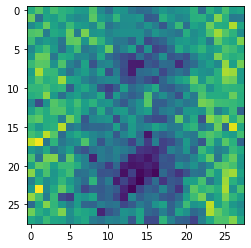

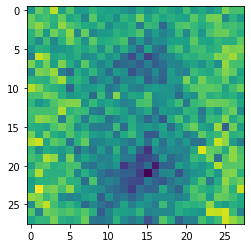

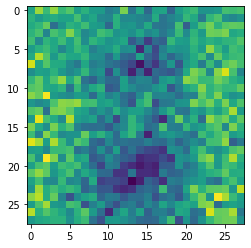

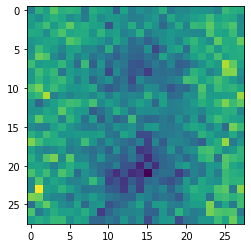

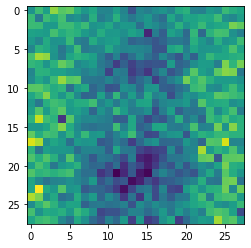

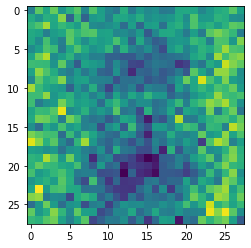

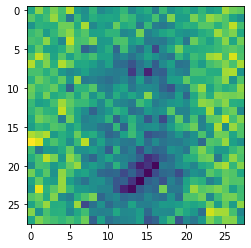

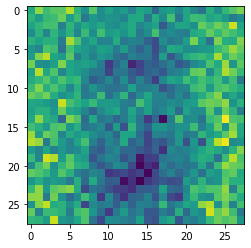

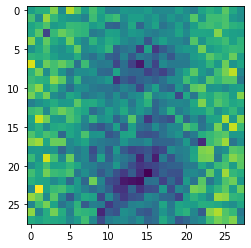

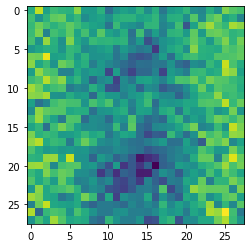

In [9]:
net_RealNVP.eval()
SAMPLES = 10
X = net_RealNVP.sample(SAMPLES).cpu()
for i in range(SAMPLES):
    plt.imshow(X[i].view(IM_SHAPE).detach().numpy())
    plt.show()
    